<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/FeatureSubsetBinaryClassifers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
analysis		       FeatureSubsetBinaryClassifers.ipynb
Analysis		       FLORES.ipynb
backward_models		       LanguageAnalysis.ipynb
BoostedBinaryClassifers.ipynb  language_models
checkpoints		       LM_Thresholding.ipynb
ClassificationDataset	       NCD_Analysis.ipynb
configs			       NNClassification.ipynb
data			       noisychannel
data-bin		       NoisyChannel.ipynb
Ensembles		     

In [2]:
pip install fairseq sacrebleu sentencepiece tqdm xgboost

     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 1.1MB 7.8MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2021173 sha256=34372e0fef17bdd088a9f1dadbd8e900141bd096eb25179001cfb333f2845d94
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [3]:
# prints how much GPU RAM is available
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1c460eabebd0ee41f3d499135280dcb9dfd6f6157abfd6b69da207bc79c37c5d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 160.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
import numpy as np
from itertools import zip_longest
from sklearn.svm import SVC
from xgboost import XGBClassifier


class CustomEnsembleClassifier:
    def __init__(self, clfs):
        self.classifiers = clfs
    
    def predict(self, X):
        probabilities = None
        for clf in self.classifiers:
            if probabilities is None:
                probabilities = clf.predict_proba(X)
            else:
                probabilities += clf.predict_proba(X)
        return np.argmax(np.array(probabilities), axis=1)


def printDatasetClassProp(Y): 
    classes = {}
    total = len(Y)
    for i in Y:
        if i in classes:
            classes[i] += 1
        else:
            classes[i] = 1
    
    for cls in classes:
        print("Proportion in class " + str(cls) + " = " + str(classes[cls]/total))

def datasetReader(featureFile, labelFile):
    files = [featureFile, labelFile]

    X = []
    Y = []

    for lines in zip_longest(*files, fillvalue=''):
        currX, currY = lines[0], float(lines[1].strip("\n"))
        Xarr = []
        features = currX.split()
        for feature in features:
            Xarr.append(float(feature.strip(",").strip("\n")))
        X.append(Xarr)
        Y.append(currY)    
    return np.array(X), np.array(Y)


def computeSimilarity(o1, o2):
    total = len(o1)
    same = 0
    for i in range(len(o1)):
        if o1[i] == o2[i]:
            same += 1
    print(same/total)

def trainExtremeGradientBoostedClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Extreme Gradient Boosted Classifier")
    
    clf = XGBClassifier()
    clf.fit(X, Y)
    return clf

def trainLogisticRegressionClassifier(X, Y, verbose=True):
    if verbose:
        print("Traning Logistic Regression Classifier")
    clf = LogisticRegression(random_state=42, max_iter=500)
    clf.fit(X, Y)
    return clf


def trainMLPClassifier(X, Y, verbose=True):
    if verbose:
        print("Training MLP Classifier")
    clf = MLPClassifier(hidden_layer_sizes=(64, 256, 512, 256, 64), random_state=42,
                        max_iter=200, learning_rate='adaptive', learning_rate_init=0.0005, activation='relu')
    clf.fit(X, Y)
    return clf

def trainKNeighborsClassifier(X, Y, verbose=True):
    if verbose:
        print("Training KNeighbors Classifier")
    clf = KNeighborsClassifier(100)
    clf.fit(X, Y)
    return clf

def trainGaussianProcessClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Gaussian Process Classifier")
    length_scale = [1 for i in range(len(X[0]))]
    clf = GaussianProcessClassifier(1.0 * RBF(length_scale), warm_start=True, random_state=42, n_jobs=-1)
    clf.fit(X, Y)
    return clf

def trainCustomEnsemble(X, Y, maxDepth=8, estimators=100, verbose=True):
    if verbose:
        print("Training custom ensemble")
    rf = RandomForestClassifier(max_depth=maxDepth, random_state=42)
    grad = GradientBoostingClassifier(random_state=42)
    ada = AdaBoostClassifier(n_estimators=estimators, random_state=42)
    lg = LogisticRegression(random_state=42, max_iter=500)
    # dl = MLPClassifier(hidden_layer_sizes=(100), random_state=1, max_iter=200)
    # kn = KNeighborsClassifier(100)

    classifiers = [rf, grad, ada, lg]

    for clf in classifiers:
        clf.fit(X, Y)

    return CustomEnsembleClassifier(classifiers)
    

def trainEnsembleClassifier(X, Y, maxDepth=8, estimators=100, verbose=True):
    if verbose:
        print("Training an ensemble of Random Forest and Gradient Boosting Classifiers")

    estimators = [
     ('rf', RandomForestClassifier(max_depth=maxDepth, random_state=42)),
     ('grad', GradientBoostingClassifier(random_state=42))]
    clf = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier(n_estimators=50, random_state=42))
    clf.fit(X, Y)
    return clf


def trainRandomForestClassifier(X, Y, maxDepth=8, verbose=True):
    if verbose:
        print("Training Random Forest classifier")
    clf = RandomForestClassifier(max_depth=maxDepth, random_state=42)
    clf.fit(X, Y)
    return clf

def trainAdaBoostClassifier(X, Y, estimators=100, verbose=True):
    if verbose:
        print("Training AdaBoosted Decision Tree classifier")
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=estimators, random_state=42)
    clf.fit(X, Y)
    return clf

def trainGradientBoostingClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Graident Boosted classifier")
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X, Y)
    return clf

def trainSVM(X, Y, verbose=True):
    if verbose:
        print("Training SVM classifier")
    clf = SVC(gamma='auto')
    clf.fit(X, Y)
    return clf

def calculateAccuracy(predictedClasses, groundTruth):
    correct_accepted = 0
    total_accepted = 0

    correct_rejected = 0
    total_rejected = 0

    for i in range(len(predictedClasses)):
        if groundTruth[i] == 1:
            total_accepted += 1
            if predictedClasses[i] == groundTruth[i]:
                correct_accepted += 1
        else:
            total_rejected += 1
            if predictedClasses[i] == groundTruth[i]:
                correct_rejected += 1


    print("Correctly accepted = " + str(100*correct_accepted/total_accepted))
    print("Incorrectly rejected = " + str(100 - 100*correct_accepted/total_accepted))
    print("Correctly rejected = " + str(100*correct_rejected/total_rejected))
    print("Incorrectly accepted = " + str(100 - 100*correct_rejected/total_rejected))

    print("Total Accuracy = " + str(100*(correct_accepted + correct_rejected)/(total_accepted + total_rejected)))

def calculatedAcceptedFraction(predictedClasses):
    return len([i for i in predictedClasses if i > 0])/len(predictedClasses)

(2559, 22)
(2559, 22)
(2835, 22)
TRAIN SET CLASS PROPORTIONS:
Proportion in class 0.0 = 0.8014849550605705
Proportion in class 1.0 = 0.19851504493942945
TEST SET CLASS PROPORTIONS
Proportion in class 1.0 = 0.2536155202821869
Proportion in class 0.0 = 0.7463844797178131

Just Forward Model score P(y|x)
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 7.874015748031496
Incorrectly rejected = 92.1259842519685
Correctly rejected = 99.07362262311068
Incorrectly accepted = 0.9263773768893202
Total Accuracy = 80.96912856584603
Percent acepted = 2.3055881203595154
Corpus BLEU score of accepted translations = 22.55
TEST ACCURACY
Correctly accepted = 9.040333796940194
Incorrectly rejected = 90.95966620305981
Correctly rejected = 98.91304347826087
Incorrectly accepted = 1.0869565217391255
Total Accuracy = 76.11992945326278
Percent acepted = 3.1040564373897706
Corpus BLEU score of accepted translations = 24.36
############


[Logistic Regression Classifier] AUC for included fraction: 10.966281750683862
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 12.818890652557318
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 23.4251968503937
Incorrectly rejected = 76.5748031496063
Correctly rejected = 99.07362262311068
Incorrectly accepted = 0.9263773768893202
Total Accuracy = 84.05627198124267
Percent acepted = 5.3927315357561545
Corpus BLEU score of accepted translations = 21.35
TEST ACCURACY
Correctly accepted = 13.490959666203059
Incorrectly rejected = 86.50904033379695
Correctly rejected = 96.17202268431002
Incorrectly accepted = 3.827977315689978
Total Accuracy = 75.20282186948853
Percent acepted = 6.278659611992945
Corpus BLEU score of accepted translations = 17.03
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 11.796524032825321
TEST SET



[Custom Ensemble] AUC for included fraction: 11.495322751322753
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 14.566929133858268
Incorrectly rejected = 85.43307086614173
Correctly rejected = 99.17113603120428
Incorrectly accepted = 0.8288639687957158
Total Accuracy = 82.37592809691286
Percent acepted = 3.5560765924189135
Corpus BLEU score of accepted translations = 23.87
TEST ACCURACY
Correctly accepted = 10.709318497913769
Incorrectly rejected = 89.29068150208623
Correctly rejected = 97.92060491493383
Incorrectly accepted = 2.0793950850661673
Total Accuracy = 75.80246913580247
Percent acepted = 4.268077601410935
Corpus BLEU score of accepted translations = 19.22
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 11.821438061742867
TEST SET



[Gradient Boosting Classifier] AUC for included fraction: 11.813880070546737
#################################################
Training Graident Boosted classifier
TRAIN ACCURACY
Correctly accepted = 21.25984251968504
Incorrectly rejected = 78.74015748031496
Correctly rejected = 99.12237932715749
Incorrectly accepted = 0.8776206728425109
Total Accuracy = 83.66549433372411
Percent acepted = 4.9237983587338805
Corpus BLEU score of accepted translations = 22.85
TEST ACCURACY
Correctly accepted = 12.100139082058414
Incorrectly rejected = 87.89986091794158
Correctly rejected = 96.88090737240076
Incorrectly accepted = 3.119092627599244
Total Accuracy = 75.37918871252205
Percent acepted = 5.396825396825397
Corpus BLEU score of accepted translations = 17.2
#################################################
TRAIN SET



[MLP Classifier] AUC for included fraction: 11.793432981633451
TEST SET



[MLP Classifier] AUC for included fraction: 11.390740740740743


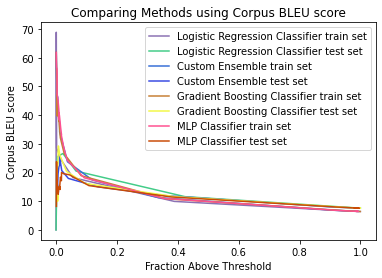




NCD features: P(y|x), p(x|y), p(y)
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 20.078740157480315
Incorrectly rejected = 79.92125984251969
Correctly rejected = 98.29351535836177
Incorrectly accepted = 1.7064846416382267
Total Accuracy = 82.76670574443142
Percent acepted = 5.353653771004298
Corpus BLEU score of accepted translations = 21.61
TEST ACCURACY
Correctly accepted = 18.08066759388039
Incorrectly rejected = 81.91933240611961
Correctly rejected = 97.2117202268431
Incorrectly accepted = 2.7882797731569013
Total Accuracy = 77.14285714285714
Percent acepted = 6.666666666666667
Corpus BLEU score of accepted translations = 21.45
#################################################
TRAIN SET



[Logistic Regression Classifier] AUC for included fraction: 11.100199296600234
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 13.035645502645504
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 35.826771653543304
Incorrectly rejected = 64.1732283464567
Correctly rejected = 99.02486591906387
Incorrectly accepted = 0.9751340809361295
Total Accuracy = 86.47909339585776
Percent acepted = 7.8937084798749515
Corpus BLEU score of accepted translations = 21.98
TEST ACCURACY
Correctly accepted = 22.11404728789986
Incorrectly rejected = 77.88595271210013
Correctly rejected = 95.08506616257088
Incorrectly accepted = 4.914933837429118
Total Accuracy = 76.57848324514991
Percent acepted = 9.27689594356261
Corpus BLEU score of accepted translations = 19.19
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 12.619486127393515
TEST SET



[Custom Ensemble] AUC for included fraction: 12.50463668430335
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 30.511811023622048
Incorrectly rejected = 69.48818897637796
Correctly rejected = 98.78108239882984
Incorrectly accepted = 1.218917601170162
Total Accuracy = 85.22860492379836
Percent acepted = 7.033997655334115
Corpus BLEU score of accepted translations = 21.85
TEST ACCURACY
Correctly accepted = 21.418636995827537
Incorrectly rejected = 78.58136300417246
Correctly rejected = 95.60491493383743
Incorrectly accepted = 4.395085066162565
Total Accuracy = 76.79012345679013
Percent acepted = 8.71252204585538
Corpus BLEU score of accepted translations = 19.62
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 12.319323954669793
TEST SET



[Gradient Boosting Classifier] AUC for included fraction: 12.735305114638447
#################################################
Training Graident Boosted classifier
TRAIN ACCURACY
Correctly accepted = 34.25196850393701
Incorrectly rejected = 65.74803149606299
Correctly rejected = 98.39102876645539
Incorrectly accepted = 1.608971233544608
Total Accuracy = 85.65846033606877
Percent acepted = 8.089097303634233
Corpus BLEU score of accepted translations = 20.7
TEST ACCURACY
Correctly accepted = 23.08762169680111
Incorrectly rejected = 76.91237830319889
Correctly rejected = 94.234404536862
Incorrectly accepted = 5.765595463137998
Total Accuracy = 76.19047619047619
Percent acepted = 10.158730158730158
Corpus BLEU score of accepted translations = 18.01
#################################################
TRAIN SET



[MLP Classifier] AUC for included fraction: 12.10225674091442
TEST SET



[MLP Classifier] AUC for included fraction: 12.03641093474427


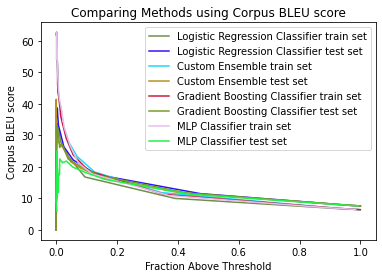




NCD features + sentence length features
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 19.881889763779526
Incorrectly rejected = 80.11811023622047
Correctly rejected = 98.00097513408093
Incorrectly accepted = 1.9990248659190684
Total Accuracy = 82.49316139116843
Percent acepted = 5.549042594763579
Corpus BLEU score of accepted translations = 20.75
TEST ACCURACY
Correctly accepted = 19.749652294853963
Incorrectly rejected = 80.25034770514604
Correctly rejected = 97.54253308128544
Incorrectly accepted = 2.457466918714559
Total Accuracy = 77.81305114638448
Percent acepted = 6.843033509700176
Corpus BLEU score of accepted translations = 21.1
#################################################
TRAIN SET



[Logistic Regression Classifier] AUC for included fraction: 10.83225087924971
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 12.482234567901234
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 40.354330708661415
Incorrectly rejected = 59.645669291338585
Correctly rejected = 99.41491955143832
Incorrectly accepted = 0.5850804485616834
Total Accuracy = 87.6905041031653
Percent acepted = 8.479874951152794
Corpus BLEU score of accepted translations = 22.12
TEST ACCURACY
Correctly accepted = 23.08762169680111
Incorrectly rejected = 76.91237830319889
Correctly rejected = 95.27410207939508
Incorrectly accepted = 4.725897920604922
Total Accuracy = 76.96649029982363
Percent acepted = 9.382716049382717
Corpus BLEU score of accepted translations = 19.07
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 12.839964830011724
TEST SET



[Custom Ensemble] AUC for included fraction: 12.514643738977073
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 32.28346456692913
Incorrectly rejected = 67.71653543307087
Correctly rejected = 98.73232569478303
Incorrectly accepted = 1.2676743052169712
Total Accuracy = 85.54122704181322
Percent acepted = 7.424775302852677
Corpus BLEU score of accepted translations = 21.46
TEST ACCURACY
Correctly accepted = 23.504867872044507
Incorrectly rejected = 76.49513212795549
Correctly rejected = 96.07750472589792
Incorrectly accepted = 3.9224952741020758
Total Accuracy = 77.67195767195767
Percent acepted = 8.88888888888889
Corpus BLEU score of accepted translations = 19.3
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 12.285982805783508
TEST SET



[Gradient Boosting Classifier] AUC for included fraction: 12.410666666666666
#################################################
Training Graident Boosted classifier
TRAIN ACCURACY
Correctly accepted = 36.811023622047244
Incorrectly rejected = 63.188976377952756
Correctly rejected = 98.29351535836177
Incorrectly accepted = 1.7064846416382267
Total Accuracy = 86.0883157483392
Percent acepted = 8.675263774912075
Corpus BLEU score of accepted translations = 20.39
TEST ACCURACY
Correctly accepted = 26.842837273991655
Incorrectly rejected = 73.15716272600835
Correctly rejected = 94.18714555765595
Incorrectly accepted = 5.812854442344047
Total Accuracy = 77.10758377425044
Percent acepted = 11.146384479717813
Corpus BLEU score of accepted translations = 18.1
#################################################
TRAIN SET



[MLP Classifier] AUC for included fraction: 12.086150840171939
TEST SET



[MLP Classifier] AUC for included fraction: 11.858278659611994


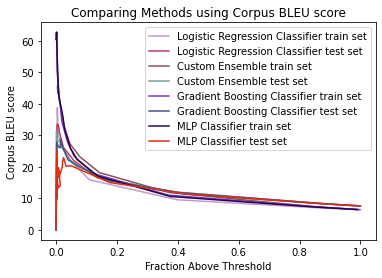




NCD features + ngram features
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 20.275590551181104
Incorrectly rejected = 79.7244094488189
Correctly rejected = 97.85470502194052
Incorrectly accepted = 2.145294978059482
Total Accuracy = 82.45408362641656
Percent acepted = 5.74443141852286
Corpus BLEU score of accepted translations = 20.27
TEST ACCURACY
Correctly accepted = 19.193324061196105
Incorrectly rejected = 80.80667593880389
Correctly rejected = 97.16446124763705
Incorrectly accepted = 2.8355387523629503
Total Accuracy = 77.38977072310405
Percent acepted = 6.984126984126984
Corpus BLEU score of accepted translations = 21.17
#################################################
TRAIN SET



[Logistic Regression Classifier] AUC for included fraction: 10.962928878468151
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 12.875121693121693
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 37.00787401574803
Incorrectly rejected = 62.99212598425197
Correctly rejected = 98.97610921501706
Incorrectly accepted = 1.0238907849829388
Total Accuracy = 86.67448221961703
Percent acepted = 8.167252833137944
Corpus BLEU score of accepted translations = 21.37
TEST ACCURACY
Correctly accepted = 23.9221140472879
Incorrectly rejected = 76.07788595271211
Correctly rejected = 94.65973534971644
Incorrectly accepted = 5.340264650283558
Total Accuracy = 76.71957671957672
Percent acepted = 10.052910052910052
Corpus BLEU score of accepted translations = 17.94
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 12.542704181320829
TEST SET



[Custom Ensemble] AUC for included fraction: 12.451548500881835
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 30.511811023622048
Incorrectly rejected = 69.48818897637796
Correctly rejected = 98.82983910287665
Incorrectly accepted = 1.1701608971233526
Total Accuracy = 85.26768268855021
Percent acepted = 6.994919890582259
Corpus BLEU score of accepted translations = 22.21
TEST ACCURACY
Correctly accepted = 22.809457579972182
Incorrectly rejected = 77.19054242002781
Correctly rejected = 95.55765595463139
Incorrectly accepted = 4.442344045368614
Total Accuracy = 77.10758377425044
Percent acepted = 9.100529100529101
Corpus BLEU score of accepted translations = 18.59
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 12.203280578350919
TEST SET



[Gradient Boosting Classifier] AUC for included fraction: 12.738809523809525
#################################################
Training Graident Boosted classifier
TRAIN ACCURACY
Correctly accepted = 34.84251968503937
Incorrectly rejected = 65.15748031496062
Correctly rejected = 97.90346172598733
Incorrectly accepted = 2.096538274012673
Total Accuracy = 85.38491598280578
Percent acepted = 8.597108245408362
Corpus BLEU score of accepted translations = 20.19
TEST ACCURACY
Correctly accepted = 25.45201668984701
Incorrectly rejected = 74.54798331015299
Correctly rejected = 93.71455576559546
Incorrectly accepted = 6.285444234404537
Total Accuracy = 76.4021164021164
Percent acepted = 11.146384479717813
Corpus BLEU score of accepted translations = 16.92
#################################################
TRAIN SET



[MLP Classifier] AUC for included fraction: 12.151141070730754
TEST SET



[MLP Classifier] AUC for included fraction: 12.05131569664903


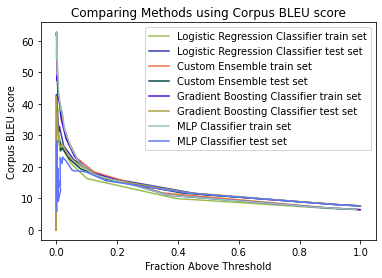




NCD features + sentence length features + Rare words
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 22.834645669291337
Incorrectly rejected = 77.16535433070867
Correctly rejected = 98.00097513408093
Incorrectly accepted = 1.9990248659190684
Total Accuracy = 83.07932786244626
Percent acepted = 6.135209066041422
Corpus BLEU score of accepted translations = 20.14
TEST ACCURACY
Correctly accepted = 20.445062586926287
Incorrectly rejected = 79.55493741307372
Correctly rejected = 96.9281663516068
Incorrectly accepted = 3.071833648393195
Total Accuracy = 77.53086419753086
Percent acepted = 7.477954144620812
Corpus BLEU score of accepted translations = 19.73
#################################################
TRAIN SET



[Logistic Regression Classifier] AUC for included fraction: 10.959710824540835
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 12.386617283950617
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 41.53543307086614
Incorrectly rejected = 58.46456692913386
Correctly rejected = 99.36616284739152
Incorrectly accepted = 0.6338371526084785
Total Accuracy = 87.88589292692458
Percent acepted = 8.753419304415786
Corpus BLEU score of accepted translations = 21.86
TEST ACCURACY
Correctly accepted = 21.974965229485395
Incorrectly rejected = 78.02503477051461
Correctly rejected = 96.36105860113422
Incorrectly accepted = 3.638941398865782
Total Accuracy = 77.49559082892416
Percent acepted = 8.289241622574956
Corpus BLEU score of accepted translations = 18.61
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 12.763876514263384
TEST SET



[Custom Ensemble] AUC for included fraction: 12.488576719576718
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 34.05511811023622
Incorrectly rejected = 65.94488188976378
Correctly rejected = 99.02486591906387
Incorrectly accepted = 0.9751340809361295
Total Accuracy = 86.12739351309105
Percent acepted = 7.542008597108245
Corpus BLEU score of accepted translations = 21.99
TEST ACCURACY
Correctly accepted = 22.531293463143253
Incorrectly rejected = 77.46870653685674
Correctly rejected = 96.40831758034027
Incorrectly accepted = 3.5916824196597332
Total Accuracy = 77.67195767195767
Percent acepted = 8.395061728395062
Corpus BLEU score of accepted translations = 18.94
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 12.218264947245018
TEST SET



[Gradient Boosting Classifier] AUC for included fraction: 12.320192239858905
#################################################
Training Graident Boosted classifier
TRAIN ACCURACY
Correctly accepted = 36.023622047244096
Incorrectly rejected = 63.976377952755904
Correctly rejected = 98.29351535836177
Incorrectly accepted = 1.7064846416382267
Total Accuracy = 85.93200468933178
Percent acepted = 8.51895271590465
Corpus BLEU score of accepted translations = 20.93
TEST ACCURACY
Correctly accepted = 25.869262865090402
Incorrectly rejected = 74.1307371349096
Correctly rejected = 94.18714555765595
Incorrectly accepted = 5.812854442344047
Total Accuracy = 76.86067019400353
Percent acepted = 10.899470899470899
Corpus BLEU score of accepted translations = 17.72
#################################################
TRAIN SET



[MLP Classifier] AUC for included fraction: 12.148798358733881
TEST SET



[MLP Classifier] AUC for included fraction: 11.888179894179894


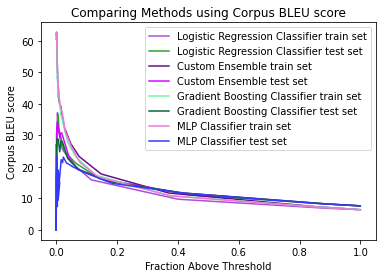




NCD features + sentence length features + end of sentence identifiers
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 19.68503937007874
Incorrectly rejected = 80.31496062992126
Correctly rejected = 98.00097513408093
Incorrectly accepted = 1.9990248659190684
Total Accuracy = 82.45408362641656
Percent acepted = 5.509964830011723
Corpus BLEU score of accepted translations = 20.53
TEST ACCURACY
Correctly accepted = 19.749652294853963
Incorrectly rejected = 80.25034770514604
Correctly rejected = 97.4007561436673
Incorrectly accepted = 2.5992438563327056
Total Accuracy = 77.70723104056438
Percent acepted = 6.9488536155202825
Corpus BLEU score of accepted translations = 20.97
#################################################
TRAIN SET



[Logistic Regression Classifier] AUC for included fraction: 10.861393122313405
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 12.495560846560847
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 37.79527559055118
Incorrectly rejected = 62.20472440944882
Correctly rejected = 99.07362262311068
Incorrectly accepted = 0.9263773768893202
Total Accuracy = 86.90894880812817
Percent acepted = 8.245408362641657
Corpus BLEU score of accepted translations = 21.68
TEST ACCURACY
Correctly accepted = 21.974965229485395
Incorrectly rejected = 78.02503477051461
Correctly rejected = 96.21928166351607
Incorrectly accepted = 3.780718336483929
Total Accuracy = 77.38977072310405
Percent acepted = 8.395061728395062
Corpus BLEU score of accepted translations = 19.23
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 12.617526377491208
TEST SET



[Custom Ensemble] AUC for included fraction: 12.603968253968254
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 30.905511811023622
Incorrectly rejected = 69.09448818897638
Correctly rejected = 98.82983910287665
Incorrectly accepted = 1.1701608971233526
Total Accuracy = 85.34583821805393
Percent acepted = 7.073075420085971
Corpus BLEU score of accepted translations = 21.59
TEST ACCURACY
Correctly accepted = 22.67037552155772
Incorrectly rejected = 77.32962447844228
Correctly rejected = 96.31379962192817
Incorrectly accepted = 3.686200378071831
Total Accuracy = 77.63668430335098
Percent acepted = 8.500881834215168
Corpus BLEU score of accepted translations = 19.62
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 12.20902500976944
TEST SET



[Gradient Boosting Classifier] AUC for included fraction: 12.513456790123456
#################################################
Training Graident Boosted classifier
TRAIN ACCURACY
Correctly accepted = 36.22047244094488
Incorrectly rejected = 63.77952755905512
Correctly rejected = 98.29351535836177
Incorrectly accepted = 1.7064846416382267
Total Accuracy = 85.97108245408363
Percent acepted = 8.558030480656505
Corpus BLEU score of accepted translations = 20.48
TEST ACCURACY
Correctly accepted = 26.564673157162726
Incorrectly rejected = 73.43532684283727
Correctly rejected = 94.70699432892249
Incorrectly accepted = 5.293005671077509
Total Accuracy = 77.42504409171076
Percent acepted = 10.687830687830688
Corpus BLEU score of accepted translations = 18.01
#################################################
TRAIN SET



[MLP Classifier] AUC for included fraction: 12.096426338413444
TEST SET



[MLP Classifier] AUC for included fraction: 11.909414462081127


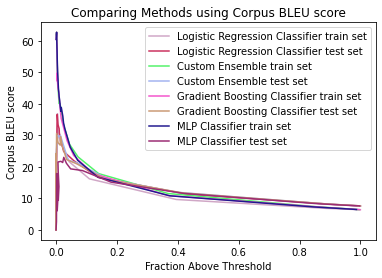




NCD features + ngram features + Rare words
#################################################
Traning Logistic Regression Classifier
TRAIN ACCURACY
Correctly accepted = 23.228346456692915
Incorrectly rejected = 76.77165354330708
Correctly rejected = 97.85470502194052
Incorrectly accepted = 2.145294978059482
Total Accuracy = 83.04025009769441
Percent acepted = 6.3305978898007025
Corpus BLEU score of accepted translations = 20.48
TEST ACCURACY
Correctly accepted = 21.974965229485395
Incorrectly rejected = 78.02503477051461
Correctly rejected = 96.64461247637051
Incorrectly accepted = 3.3553875236294886
Total Accuracy = 77.70723104056438
Percent acepted = 8.077601410934744
Corpus BLEU score of accepted translations = 19.91
#################################################
TRAIN SET



[Logistic Regression Classifier] AUC for included fraction: 10.973290347792105
TEST SET



[Logistic Regression Classifier] AUC for included fraction: 12.358165784832451
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 35.43307086614173
Incorrectly rejected = 64.56692913385827
Correctly rejected = 99.2686494392979
Incorrectly accepted = 0.7313505607020971
Total Accuracy = 86.59632669011333
Percent acepted = 7.620164126611957
Corpus BLEU score of accepted translations = 21.71
TEST ACCURACY
Correctly accepted = 22.11404728789986
Incorrectly rejected = 77.88595271210013
Correctly rejected = 95.46313799621929
Incorrectly accepted = 4.536862003780712
Total Accuracy = 76.86067019400353
Percent acepted = 8.994708994708994
Corpus BLEU score of accepted translations = 17.75
#################################################
TRAIN SET



[Custom Ensemble] AUC for included fraction: 12.576793669402111
TEST SET



[Custom Ensemble] AUC for included fraction: 12.377851851851851
#################################################
Training custom ensemble
TRAIN ACCURACY
Correctly accepted = 31.10236220472441
Incorrectly rejected = 68.89763779527559
Correctly rejected = 98.82983910287665
Incorrectly accepted = 1.1701608971233526
Total Accuracy = 85.38491598280578
Percent acepted = 7.112153184837827
Corpus BLEU score of accepted translations = 21.69
TEST ACCURACY
Correctly accepted = 22.531293463143253
Incorrectly rejected = 77.46870653685674
Correctly rejected = 95.74669187145558
Incorrectly accepted = 4.253308128544418
Total Accuracy = 77.17813051146385
Percent acepted = 8.88888888888889
Corpus BLEU score of accepted translations = 18.49
#################################################
TRAIN SET



[Gradient Boosting Classifier] AUC for included fraction: 12.146535756154746
TEST SET


KeyboardInterrupt: ignored

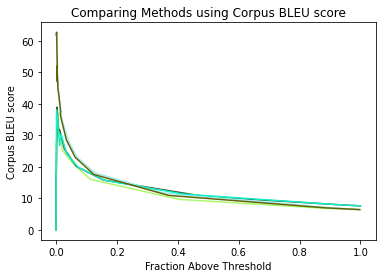

In [10]:
##make precision graphs
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random
from tqdm.notebook import tqdm

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    if len(acceptedTranslations) != 0:
        temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.data", "w")
        temporary_output_inclusion = open("analysis/temporary_output_inclusion.data", "w")

    
        for translation in acceptedTranslations:
            temporary_reference_inclusion.write(translation.reference)
            temporary_output_inclusion.write(translation.translation)

        temporary_reference_inclusion.close()
        temporary_output_inclusion.close()


        !fairseq-score --sys analysis/temporary_output_inclusion.data --ref analysis/temporary_reference_inclusion.data --sacrebleu > analysis/inclusion_result.data

        temporary_inclusion_result = open("analysis/inclusion_result.data")
        inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]

        temporary_reference_inclusion.close()
        temporary_output_inclusion.close()
        temporary_inclusion_result.close()

    else:
        inclusion_result_string = "0"

    if len(rejectedTranslations) != 0:

        temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.data", "w")
        temporary_output_exclusion = open("analysis/temporary_output_exclusion.data", "w")
        
        for translation in rejectedTranslations:
            temporary_reference_exclusion.write(translation.reference)
            temporary_output_exclusion.write(translation.translation)

        
        temporary_reference_exclusion.close()
        temporary_output_exclusion.close()

        !fairseq-score --sys analysis/temporary_output_exclusion.data --ref analysis/temporary_reference_exclusion.data --sacrebleu > analysis/exclusion_result.data

        temporary_exclusion_result = open("analysis/exclusion_result.data")
        exclusion_result_string = "0" if len(rejectedTranslations) == 0 else [line for line in temporary_exclusion_result][1].split(" ")[2]

        temporary_reference_exclusion.close()
        temporary_output_exclusion.close()
        temporary_exclusion_result.close()
    
    else:
        exclusion_result_string = "0"

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

# featuresUsed = [0, 5, 6, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
# featuresUsed = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] ##All
avgLogProb = [False, False, False, False]
featuresUsed = [0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# featuresUsed = [10, 11, 12]
# featureSubsets = [[0], #just baseline Forward Model score [P(T|S)]
#                   [0, 11, 12], #Similar to noisy channel decoding: P(y|x), p(x|y), p(y) 
#                   [0, 11, 12, 19, 20], #Like above + sentence length features
#                   [0, 11, 12, 16, 17, 18], #Like above + ngram features
#                   [0, 5, 6, 11, 12, 19, 20], #Like above + sentence length features + Rare words
#                   [0, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + end of sentence identifiers
#                   [0, 5, 6, 11, 12, 16, 17, 18], #Like above + ngram features + Rare words
#                   [0, 11, 12, 13, 14, 16, 17, 18], #Like above + ngram features + end of sentence identifiers
#                   [0, 5, 6, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + Rare words + end of sentence identifiers
#                   [0, 5, 6, 11, 12, 13, 14, 16, 17, 18] #Like above + ngram features + Rare words + end of sentence identifiers
#                   ]
# featureSubsetDetails = ["Just Forward Model score P(y|x)",
#                         "NCD features: P(y|x), p(x|y), p(y)",
#                         "NCD features + sentence length features",
#                         "NCD features + ngram features",
#                         "NCD features + sentence length features + Rare words",
#                         "NCD features + sentence length features + end of sentence identifiers",
#                         "NCD features + ngram features + Rare words",
#                         "NCD features + ngram features + end of sentence identifiers",
#                         "NCD features + sentence length features + Rare words + end of sentence identifiers",
#                         "NCD features + ngram features + Rare words + end of sentence identifiers"]
featureSubsets = [[0], #just baseline Forward Model score [P(T|S)]
                  [0, 11, 12], #Similar to noisy channel decoding: P(y|x), p(x|y), p(y) 
                  [0, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + end of sentence identifiers
                  [0, 11, 12, 13, 14, 16, 17, 18], #Like above + ngram features + end of sentence identifiers
                  [0, 5, 6, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + Rare words + end of sentence identifiers
                  [0, 5, 6, 11, 12, 13, 14, 16, 17, 18] #Like above + ngram features + Rare words + end of sentence identifiers
                  [0, 1, 2, 5, 6, ]
                  ]
featureSubsetDetails = ["Just Forward Model score P(y|x)",
                        "NCD features: P(y|x), p(x|y), p(y)",
                        "NCD features + sentence length features + end of sentence identifiers",
                        "NCD features + ngram features + end of sentence identifiers",
                        "NCD features + sentence length features + Rare words + end of sentence identifiers",
                        "NCD features + ngram features + Rare words + end of sentence identifiers"]

trainThresholds = [np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist()]
testThresholds = [np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist()]
modelLabel = {0: "Logistic Regression Classifier", 1: "Random Forest Classifier", 2: "Custom Ensemble", 3: "Gradient Boosting", 4: "Extreme Gradient Boosting"}
trainset = "valid"
testset = "test"
bleuThresholdTrain = 15
bleuThresholdTest = 15

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.data")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.data")

trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.data")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.data")

trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.data")
testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.data")

fullTrainX, fullTrainY = datasetReader(trainFeatures, trainLabels)
fullTestX, fullTestY = datasetReader(testFeatures, testLabels)
featuresTrain = fullTrainX
featuresTest = fullTestX
print(featuresTrain.shape)
# print(len(trainX[0]))
# print(len(testX[0]))

print(np.array(fullTrainX).shape)
print(np.array(fullTestX).shape)
print("TRAIN SET CLASS PROPORTIONS:")
printDatasetClassProp(fullTrainY)
print("TEST SET CLASS PROPORTIONS")
printDatasetClassProp(fullTestY)
print()
classifiers = [trainLogisticRegressionClassifier]

trainFeatures.close()
trainLabels.close()
testFeatures.close()
testLabels.close()
trainSentences.close()
testSentences.close()

for ind, subset in enumerate(featureSubsets):
    print(featureSubsetDetails[ind])
    trainX = [[row[i] for i in subset] for row in fullTrainX]
    testX = [[row[i] for i in subset] for row in fullTestX]
    classifiers = [trainLogisticRegressionClassifier, trainRandomForestClassifier, trainCustomEnsemble, trainGradientBoostingClassifier, trainExtremeGradientBoostedClassifier]
    outputs = []
    models = []
    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel('Corpus BLEU score') 
    plt.title('Comparing Methods using Corpus BLEU score')
    for j, classifier in enumerate(classifiers):
        currFeaturesTrain = [[row[i] for i in featureSubsets[ind]] for row in featuresTrain]
        currFeaturesTest = [[row[i] for i in featureSubsets[ind]] for row in featuresTest]
        trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.data")
        testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.data")
        trainTranslations = readTranslations(trainSentences, currFeaturesTrain)
        testTranslations = readTranslations(testSentences, currFeaturesTest)

        print("#################################################")
        trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, 15, 15, False)
        clf = classifier(trainFeatures, trainY, verbose=True)
        print("TRAIN ACCURACY")
        predictions = np.array(clf.predict(trainFeatures))
        calculateAccuracy(predictions, trainY)
        print("Percent acepted = " + str(100 * calculatedAcceptedFraction(predictions)))
        acceptedTranslations = np.array(trainTranslations)[np.array(predictions) > 0]
        rejectedTranslations = np.array(trainTranslations)[np.array(predictions) < 1]
        _, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
        print("Corpus BLEU score of accepted translations = " + str(acceptedScore))

        print("TEST ACCURACY")
        predictions = np.array(clf.predict(testFeatures))
        calculateAccuracy(predictions, testY)
        print("Percent acepted = " + str(100 * calculatedAcceptedFraction(predictions)))
        acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
        rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
        _, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
        print("Corpus BLEU score of accepted translations = " + str(acceptedScore))

        outputs.append(predictions)
        models.append(clf)
        print("#################################################")

        acceptedScores = []
        acceptedFraction = []
        print("TRAIN SET")
        for index in tqdm(range(len(testThresholds[j]))):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[j][index], testThresholds[j][index], avgLogProb[j])
            clf = classifier(trainFeatures, trainY, verbose=False)
            predictions = clf.predict(trainFeatures)
            
            acceptedTranslations = np.array(trainTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(trainTranslations)[np.array(predictions) < 1]
                
            rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
            # print("Current threshold = " + str(testThresholds[j][index]) + " Current accepted Fraction = " + str(float(len(acceptedTranslations))/float(len(predictions))))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[j]+" train set", color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()
        print("["+modelLabel[j]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))

        acceptedScores = []
        acceptedFraction = []
        print("TEST SET")
        for index in tqdm(range(len(testThresholds[j]))):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[j][index], testThresholds[j][index], avgLogProb[j])
            clf = classifier(trainFeatures, trainY, verbose=False)
            predictions = clf.predict(testFeatures)
            
            acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
                
            rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[j]+" test set", color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()

        print("["+modelLabel[j]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))
    plt.legend(loc="upper right")
    plt.show()
    print("\n\n")

In [0]:
from sklearn.model_selection import KFold
import time
import tqdm


dataset = "test"
bleuThreshold = 15
featureFile = open("ClassificationDataset/"+str(bleuThreshold)+"BLEU/"+dataset+"/features.data")
labelFile = open("ClassificationDataset/"+str(bleuThreshold)+"BLEU/"+dataset+"/result.data")
featuresUsed = [0]

inputs, labels = datasetReader(featureFile, labelFile)
for classifier in classifiers:
    features = np.array([[row[i] for i in featuresUsed] for row in inputs])
    kf = KFold(n_splits=len(features))

    numCorrectTest = 0
    currIter = 0
    numCorrectTrain = 0
    for train_index, test_index in kf.split(features):
        trainX, trainY = features[train_index], labels[train_index]
        testX, testY = features[test_index], labels[test_index]
        if currIter == 0:
            curr = classifier(trainX, trainY, verbose=True)
        else:
            curr = classifier(trainX, trainY, verbose=False)
        
        predictions = np.array(curr.predict(trainX))
        for index, prediction in enumerate(predictions):
            if prediction == trainY[index]:
                numCorrectTrain += 1
        
        prediction = np.array(curr.predict(testX))

        if prediction[0] == testY[0]:
            numCorrectTest += 1
        
        currIter += 1
        #   print("Current Accuracy = " + str(float(numCorrect)/float(currIter)))
    trainTotal = len(features) * (len(features) - 1)
    print("Total Train Accuracy = " + str(numCorrectTrain/trainTotal))
    print("Total Test Accuracy = " + str(numCorrectTest/len(features)))

featureFile.close()
labelFile.close()



Traning Logistic Regression Classifier
Total Train Accuracy = 0.7682539682539683
Total Test Accuracy = 0.7682539682539683


In [0]:
##make precision graphs
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.data", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.data", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.data", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.data", "w")
    
    for translation in acceptedTranslations:
        temporary_reference_inclusion.write(translation.reference)
        temporary_output_inclusion.write(translation.translation)

    for translation in rejectedTranslations:
        temporary_reference_exclusion.write(translation.reference)
        temporary_output_exclusion.write(translation.translation)

    
    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.data --ref analysis/temporary_reference_inclusion.data --sacrebleu > analysis/inclusion_result.data
    !fairseq-score --sys analysis/temporary_output_exclusion.data --ref analysis/temporary_reference_exclusion.data --sacrebleu > analysis/exclusion_result.data

    temporary_inclusion_result = open("analysis/inclusion_result.data")
    temporary_exclusion_result = open("analysis/exclusion_result.data")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

# featuresUsed = [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# featuresUsed = [0]
# featuresUsed = [0, 4]

trainset = "valid"
testset = "test"
bleuThresholdTrain = 15
bleuThresholdTest = 15

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.data")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.data")
trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.data")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.data")

trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.data")
testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.data")


featuresTrain, _ = datasetReader(trainFeatures, trainLabels)
featuresTest, _ = datasetReader(testFeatures, testLabels)

featuresTrain = [[row[i] for i in featuresUsed] for row in featuresTrain]
featuresTest = [[row[i] for i in featuresUsed] for row in featuresTest]

trainTranslations = readTranslations(trainSentences, featuresTrain)
testTranslations = readTranslations(testSentences, featuresTest)

# Thresholds_train = np.linspace(-1.5, 0, 25).tolist()
Thresholds_train = np.linspace(4, 28, 25).tolist()

Thresholds_test = np.linspace(4, 28, 25).tolist()

acceptedScores = []
acceptedFraction = []

useSentenceBLEUScore = True


for index in range(len(Thresholds_test)):
    trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, Thresholds_train[index], Thresholds_test[index])

    clf = trainSVM(trainFeatures, trainY)
    # print("Using Average Logprob Decision Stump of " + str(Thresholds_train[index]))
    # print("BLEU score = " + str(Thresholds_test[index]))
    predictions = clf.predict(testFeatures)
    # calculateAccuracy(predictions, testY)
    # print("##########################################")
    acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
    rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
    if useSentenceBLEUScore:
        rejectedScore, acceptedScore = compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations)
    else:
        rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
    acceptedScores.append(acceptedScore)
    acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (average)') 
plt.title('Random Forest Thresholding') 

r = random.random()
b = random.random()
g = random.random()
c = (r, g, b)
plt.scatter(acceptedFraction, acceptedScores, label = "Random Forest Analysis", color=c)

acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
acceptedFraction.sort()

print('AUC for incuded fraction: {}'.format(auc(acceptedFraction, acceptedScores)))






Experimenting with multiple parameters and plotting curves on the same graph

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    if len(acceptedTranslations) != 0:
        temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.data", "w")
        temporary_output_inclusion = open("analysis/temporary_output_inclusion.data", "w")

    
        for translation in acceptedTranslations:
            temporary_reference_inclusion.write(translation.reference)
            temporary_output_inclusion.write(translation.translation)

        temporary_reference_inclusion.close()
        temporary_output_inclusion.close()


        !fairseq-score --sys analysis/temporary_output_inclusion.data --ref analysis/temporary_reference_inclusion.data --sacrebleu > analysis/inclusion_result.data

        temporary_inclusion_result = open("analysis/inclusion_result.data")
        inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]

    else:
        inclusion_result_string = "0"

    if len(rejectedTranslations) != 0:

        temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.data", "w")
        temporary_output_exclusion = open("analysis/temporary_output_exclusion.data", "w")
        
        for translation in rejectedTranslations:
            temporary_reference_exclusion.write(translation.reference)
            temporary_output_exclusion.write(translation.translation)

        
        temporary_reference_exclusion.close()
        temporary_output_exclusion.close()

        !fairseq-score --sys analysis/temporary_output_exclusion.data --ref analysis/temporary_reference_exclusion.data --sacrebleu > analysis/exclusion_result.data

        temporary_exclusion_result = open("analysis/exclusion_result.data")
        exclusion_result_string = "0" if len(rejectedTranslations) == 0 else [line for line in temporary_exclusion_result][1].split(" ")[2]
    
    else:
        exclusion_result_string = "0"

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

trainset = "valid"
testset = "test"
bleuThresholdTrain = 15
bleuThresholdTest = 15

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.data")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.data")
trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.data")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.data")


featuresTrain, _ = datasetReader(trainFeatures, trainLabels)
featuresTest, _ = datasetReader(testFeatures, testLabels)

In [0]:
featuresUsed = [[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [0], [4]]
trainThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(-1.5, -0.25, 25).tolist(), np.linspace(1, 60, 25).tolist()]
testThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(4, 28, 25).tolist(), np.linspace(1, 60, 25).tolist()]

evaluationMetrics = [compute_exclued_included_sentenceBleuScore, compute_excluded_included_score]
evalLabel = {0: "Average Sentence BLEU score", 1: "Corpus BLEU score"}
models = [trainRandomForestClassifier, trainRandomForestClassifier, trainRandomForestClassifier]
modelLabel = {0: "Random Forest Classifier (all features)", 1: "Average Logprob Thresholding", 2: "Sentence BLEU Thresholding"}
avgLogProb = [False, True, False]
acceptedScores = []
acceptedFraction = []


for evalMetric in range(len(evaluationMetrics)):
    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel(evalLabel[evalMetric]) 
    plt.title('Comparing Methods using ' + evalLabel[evalMetric])

    for model in range(len(models)):
        currFeaturesTrain = [[row[i] for i in featuresUsed[model]] for row in featuresTrain]
        currFeaturesTest = [[row[i] for i in featuresUsed[model]] for row in featuresTest]


        trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.data")
        testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.data")

        trainTranslations = readTranslations(trainSentences, currFeaturesTrain)
        testTranslations = readTranslations(testSentences, currFeaturesTest)

        acceptedScores = []
        acceptedFraction = []

        for index in range(len(testThresholds[model])):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[model][index], testThresholds[model][index], avgLogProb[model])
            clf = models[model](trainFeatures, trainY, verbose=False)
            predictions = clf.predict(testFeatures)
            
            acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
              
            rejectedScore, acceptedScore = evaluationMetrics[evalMetric](acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[model], color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()

        print("["+modelLabel[model]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))
    plt.legend(loc="upper right")
    plt.show()

